In [1]:
#Imports
import numpy as np
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score,f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression as SklearnLogReg
from urllib.request import urlretrieve
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Download datasets
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"  #KDD cup'99 dataset
filename = "kddcup.data_10_percent.gz"
urlretrieve(url, filename)

train_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTrain+.txt" #Train Dataset of NSL-KDD Dataset
test_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTest+.txt"   #Test dataset of NSL-KDD Dataset

train_file = "KDDTrain+.txt"
test_file = "KDDTest+.txt"

if not os.path.exists(filename):
    print("Downloading 10% KDD Cup'99 dataset...")
    urlretrieve(train_url, train_file)
if not os.path.exists(train_file):
    print("Downloading training dataset of NSL-KDD...")
    urlretrieve(train_url, train_file)
if not os.path.exists(test_file):
    print("Downloading testing dataset of NSL-KDD...")
    urlretrieve(test_url, test_file)
print('Datasets have been downloaded.')

In [2]:
filename = "kddcup.data_10_percent.gz"
train_file = "KDDTrain+.txt"
test_file = "KDDTest+.txt"

In [41]:
#Custom Logistic Regression Class
class LogisticRegression():
    def __init__(self, alpha=0.01, epochs=1000, threshold=0.5):
        self.alpha = alpha
        self.epochs = epochs
        self.threshold = threshold  # default threshold
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0

        for _ in tqdm(range(self.epochs), desc="Training Progress", unit="epoch"):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            self.weights -= self.alpha * dw
            self.bias -= self.alpha * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X, threshold=None):
        if threshold is None:
            threshold = self.threshold
        return (self.predict_proba(X) >= threshold).astype(int)


In [42]:
#Function to plot variation of f1-score as decision threshold is varied in the Logistic Regression model
def plot_threshold_vs_metrics(y_true, y_probs):
    thresholds = np.linspace(0.01, 0.99, 99)
    precisions, recalls, f1s = [], [], []

    for t in thresholds:
        preds = (y_probs >= t).astype(int)
        precisions.append(precision_score(y_true, preds))
        recalls.append(recall_score(y_true, preds))
        f1s.append(f1_score(y_true, preds))

    best_idx = np.argmax(f1s)
    best_thresh = thresholds[best_idx]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label="Precision", linestyle="--", marker="o")
    plt.plot(thresholds, recalls, label="Recall", linestyle="--", marker="x")
    plt.plot(thresholds, f1s, label="F1 Score", linewidth=2, color='black')

    plt.axvline(best_thresh, color='red', linestyle=':', label=f"Best Threshold = {best_thresh:.2f}")
    plt.title("Threshold vs Precision, Recall, and F1 Score")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Best Threshold (by F1): {best_thresh:.2f}")
    return best_thresh

In [43]:
#Function written to plot confusion matrix using matplotlib and seaborn
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [44]:
#Function to calculate and display metrics accuracy, precision,recall, f1-score
def calculateAndDisplayEvaluationMetrics(y_test, y_pred,title):
    accuracy = accuracy_score(y_test,y_pred)*100
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    plot_confusion_matrix(y_test, y_pred, title)

In [ ]:
def tune_hyperparameters_custom(X_train, y_train, X_val, y_val):
    alphas = [0.001, 0.01, 0.1, 0.5, 1]
    epochs_list = [500, 1000, 2000]
    best_f1 = 0
    best_alpha = None
    best_epochs = None
    best_threshold = 0.5
    
    # Matrix to store F1 scores for heatmap
    f1_scores = np.zeros((len(alphas), len(epochs_list)))
    thresholds = np.zeros((len(alphas), len(epochs_list)))
    
    for i, alpha in enumerate(alphas):
        for j, epochs in enumerate(epochs_list):
            print(f"Testing with alpha={alpha}, epochs={epochs}")
            log_reg = LogisticRegression(alpha=alpha, epochs=epochs)
            log_reg.fit(X_train, y_train)
            
            # Evaluating on validation set
            y_probs = log_reg.predict_proba(X_val)
            
            # Find best threshold
            thresh_values = np.linspace(0.01, 0.99, 99)
            best_local_f1 = 0
            best_local_threshold = 0.5
            
            for t in thresh_values:
                preds = (y_probs >= t).astype(int)
                f1 = f1_score(y_val, preds)
                if f1 > best_local_f1:
                    best_local_f1 = f1
                    best_local_threshold = t
            
            # Store values for heatmap
            f1_scores[i, j] = best_local_f1
            thresholds[i, j] = best_local_threshold
            
            print(f"Alpha={alpha}, Epochs={epochs}, Best Threshold={best_local_threshold:.2f}, F1={best_local_f1:.4f}")
            
            if best_local_f1 > best_f1:
                best_f1 = best_local_f1
                best_alpha = alpha
                best_epochs = epochs
                best_threshold = best_local_threshold
    
    # Create heatmap for F1 scores
    plt.figure(figsize=(10, 6))
    sns.heatmap(f1_scores, annot=True, fmt=".4f", cmap="YlGnBu",
                xticklabels=epochs_list, yticklabels=alphas)
    plt.title("F1 Scores for Custom Logistic Regression Hyperparameters")
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate (alpha)")
    plt.tight_layout()
    plt.show()
    
    # Create heatmap for best thresholds
    plt.figure(figsize=(10, 6))
    sns.heatmap(thresholds, annot=True, fmt=".2f", cmap="Oranges",
                xticklabels=epochs_list, yticklabels=alphas)
    plt.title("Best Thresholds for Custom Logistic Regression Hyperparameters")
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate (alpha)")
    plt.tight_layout()
    plt.show()
    
    print(f"\nBest Parameters: alpha={best_alpha}, epochs={best_epochs}, threshold={best_threshold:.2f}")
    print(f"Best Validation F1 Score: {best_f1:.4f}")
    
    return best_alpha, best_epochs, best_threshold

In [46]:
# (a) Evluating on 1st dataset- KDD Cup '99

#defining columns (naming each of the 41 features+ the target label vector)
KDDCup_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Loading dataset in dataframe using pandas
df = pd.read_csv(filename, names=KDDCup_columns)

#Removes duplicate rows(data cleaning)
print(df.shape)
df = df.drop_duplicates()  
print(df.shape)

print(df['label'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count as a 

#Therefore, we can see that the KDD Dataset contains lot of redundant(duplicate) data and is highly imbalanced



(494021, 42)
(145586, 42)
{'normal.': 87832, 'neptune.': 51820, 'back.': 968, 'teardrop.': 918, 'satan.': 906, 'warezclient.': 893, 'ipsweep.': 651, 'smurf.': 641, 'portsweep.': 416, 'pod.': 206, 'nmap.': 158, 'guess_passwd.': 53, 'buffer_overflow.': 30, 'warezmaster.': 20, 'land.': 19, 'imap.': 12, 'rootkit.': 10, 'loadmodule.': 9, 'ftp_write.': 8, 'multihop.': 7, 'phf.': 4, 'perl.': 3, 'spy.': 2}


In [47]:
#Preprocessing Data

# Convert categorical columns using Label Encoding (since, ML Models can only take in numerical features and not text)
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Converting target labels to binary, ie, 0 if normal and 1 if attack
df["label"] = df["label"].apply(lambda x: 0 if x == "normal." else 1)

X = df.drop("label", axis=1).values # Extracting features
y = df["label"].values #Extracting labels


# First split into train+val and test (80-20)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split train+val into train and validation (75-25, which makes the overall split 60-20-20)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)




Testing with alpha=0.001, epochs=500


Training Progress: 100%|██████████| 500/500 [00:04<00:00, 109.66epoch/s]


Alpha=0.001, Epochs=500, Best Threshold=0.56, F1=0.9581
Testing with alpha=0.001, epochs=1000


Training Progress: 100%|██████████| 1000/1000 [00:09<00:00, 100.52epoch/s]


Alpha=0.001, Epochs=1000, Best Threshold=0.55, F1=0.9583
Testing with alpha=0.001, epochs=2000


Training Progress: 100%|██████████| 2000/2000 [00:20<00:00, 99.21epoch/s] 


Alpha=0.001, Epochs=2000, Best Threshold=0.47, F1=0.9682
Testing with alpha=0.01, epochs=500


Training Progress: 100%|██████████| 500/500 [00:04<00:00, 101.97epoch/s]


Alpha=0.01, Epochs=500, Best Threshold=0.59, F1=0.9699
Testing with alpha=0.01, epochs=1000


Training Progress: 100%|██████████| 1000/1000 [00:09<00:00, 104.29epoch/s]


Alpha=0.01, Epochs=1000, Best Threshold=0.61, F1=0.9711
Testing with alpha=0.01, epochs=2000


Training Progress: 100%|██████████| 2000/2000 [00:20<00:00, 97.31epoch/s]


Alpha=0.01, Epochs=2000, Best Threshold=0.64, F1=0.9736
Testing with alpha=0.1, epochs=500


Training Progress: 100%|██████████| 500/500 [00:05<00:00, 98.88epoch/s] 


Alpha=0.1, Epochs=500, Best Threshold=0.60, F1=0.9777
Testing with alpha=0.1, epochs=1000


Training Progress: 100%|██████████| 1000/1000 [00:09<00:00, 108.92epoch/s]


Alpha=0.1, Epochs=1000, Best Threshold=0.55, F1=0.9780
Testing with alpha=0.1, epochs=2000


Training Progress: 100%|██████████| 2000/2000 [00:17<00:00, 117.55epoch/s]


Alpha=0.1, Epochs=2000, Best Threshold=0.60, F1=0.9778
Testing with alpha=0.5, epochs=500


Training Progress: 100%|██████████| 500/500 [00:04<00:00, 110.89epoch/s]


Alpha=0.5, Epochs=500, Best Threshold=0.28, F1=0.9785
Testing with alpha=0.5, epochs=1000


Training Progress: 100%|██████████| 1000/1000 [00:06<00:00, 160.34epoch/s]


Alpha=0.5, Epochs=1000, Best Threshold=0.22, F1=0.9815
Testing with alpha=0.5, epochs=2000


Training Progress: 100%|██████████| 2000/2000 [00:20<00:00, 99.94epoch/s] 


Alpha=0.5, Epochs=2000, Best Threshold=0.29, F1=0.9858


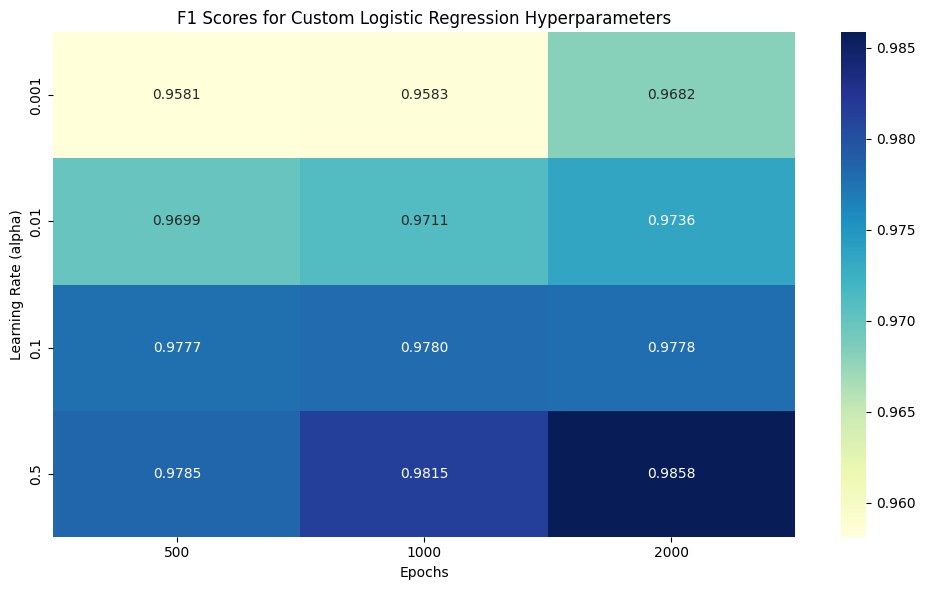

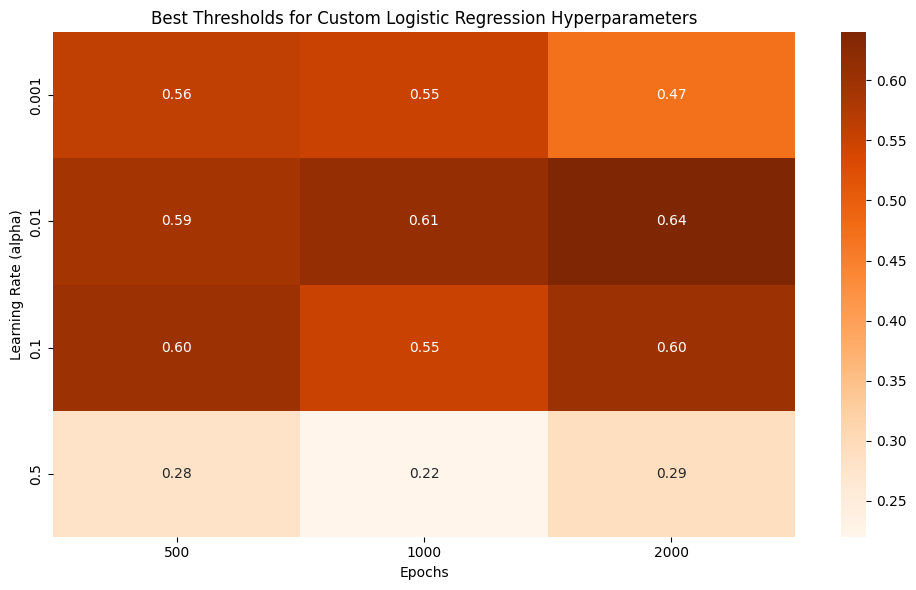


Best Parameters: alpha=0.5, epochs=2000, threshold=0.29
Best Validation F1 Score: 0.9858


In [48]:
best_alpha, best_epochs, best_threshold = tune_hyperparameters_custom(X_train, y_train, X_val, y_val)

In [38]:
print("\nTraining final model with best parameters...")
log_reg = LogisticRegression(alpha=best_alpha, epochs=best_epochs)
log_reg.fit(X_train, y_train)


Training final model with best parameters...


Training Progress: 100%|██████████| 500/500 [00:04<00:00, 121.79epoch/s]



Training set performance:
Model Accuracy: 98.82%
Precision: 0.9836
Recall: 0.9868
F1 Score: 0.9852


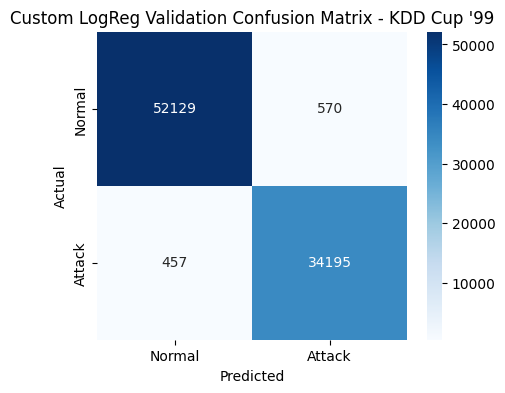


Validation set performance:
Model Accuracy: 98.87%
Precision: 0.9831
Recall: 0.9886
F1 Score: 0.9858


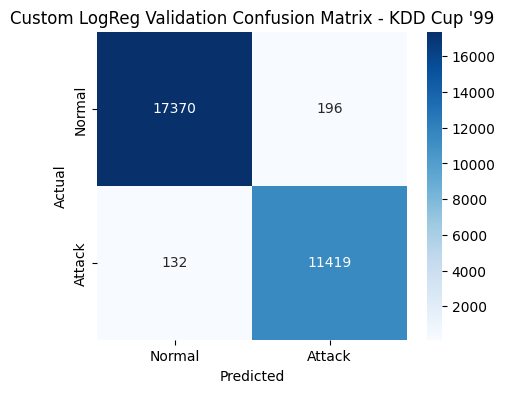


Test set performance:
Model Accuracy: 98.83%
Precision: 0.9834
Recall: 0.9873
F1 Score: 0.9853


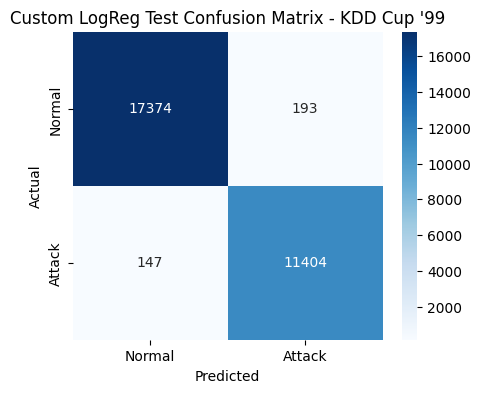

In [19]:
# Evaluate on training set
y_train_probs = log_reg.predict_proba(X_train)
y_train_pred = (y_train_probs >= best_threshold).astype(int)
print("\nTraining set performance:")
calculateAndDisplayEvaluationMetrics(y_train, y_train_pred, "Custom LogReg Validation Confusion Matrix - KDD Cup '99")

# Evaluate on validation set
y_val_probs = log_reg.predict_proba(X_val)
y_val_pred = (y_val_probs >= best_threshold).astype(int)
print("\nValidation set performance:")
calculateAndDisplayEvaluationMetrics(y_val, y_val_pred, "Custom LogReg Validation Confusion Matrix - KDD Cup '99")

# Evaluate on test set
y_test_probs = log_reg.predict_proba(X_test)
y_test_pred = (y_test_probs >= best_threshold).astype(int)
print("\nTest set performance:")
calculateAndDisplayEvaluationMetrics(y_test, y_test_pred, "Custom LogReg Test Confusion Matrix - KDD Cup '99")

In [ ]:
#Comparing with sklearn inbuilt logistic regression function
log_reg = SklearnLogReg(max_iter=500)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
calculateAndDisplayEvaluationMetrics(y_test, y_pred, "Confusion Matrix(Sklearn implementation) - KDD Cup '99" )


In [ ]:
# Get only the probabilities for class 1
y_probs = log_reg.predict_proba(X_test)[:, 1]

# Tune threshold
best_thresh = plot_threshold_vs_metrics(y_test, y_probs)

# Predict with custom threshold
y_pred_thresh = (y_probs >= best_thresh).astype(int)

# Final evaluation
calculateAndDisplayEvaluationMetrics(y_test, y_pred_thresh, f"Final Confusion Matrix - Threshold = {best_thresh:.2f}")


In [35]:
# (B) Evaluating on 2nd dataset- NSL-KDD

KDDNSL_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "class", "difficulty"
]

#Converting train and test files into dataframes
train_df = pd.read_csv(train_file, names=KDDNSL_columns, header=None) 
test_df = pd.read_csv(test_file, names=KDDNSL_columns, header=None)

#Dropping the difficulty column as not relevant for training
train_df.drop("difficulty", axis=1, inplace=True)
test_df.drop("difficulty", axis=1, inplace=True)

#Removes duplicate rows(data cleaning)
print(df.shape)
df = df.drop_duplicates()  
print(df.shape)

print(train_df['class'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count as a dictionary

#Clearly, we can see that this dataset is more balanced and does not contain duplicates as such



(145585, 42)
(145585, 42)
{'normal': 67343, 'neptune': 41214, 'satan': 3633, 'ipsweep': 3599, 'portsweep': 2931, 'smurf': 2646, 'nmap': 1493, 'back': 956, 'teardrop': 892, 'warezclient': 890, 'pod': 201, 'guess_passwd': 53, 'buffer_overflow': 30, 'warezmaster': 20, 'land': 18, 'imap': 11, 'rootkit': 10, 'loadmodule': 9, 'ftp_write': 8, 'multihop': 7, 'phf': 4, 'perl': 3, 'spy': 2}


In [36]:
#Data Preprocessing

# Label encode categorical columns(to convert features to numerical values)
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()

for col in categorical_cols:
    train_df[col] = encoder.fit_transform(train_df[col])  # Fit + transform on train
    test_df[col] = encoder.transform(test_df[col])  # Transform only on test (NO FIT)

# Convert class labels to binary (0 for normal, 1 for attack)
train_df["class"] = train_df["class"].apply(lambda x: 0 if x == "normal" else 1)
test_df["class"] = test_df["class"].apply(lambda x: 0 if x == "normal" else 1)


# Split train into train and validation (70-30)
train_data, val_data = train_test_split(train_df, test_size=0.3, random_state=42, stratify=train_df["class"])

# Split features and labels
X_train = train_data.drop("class", axis=1).values
y_train = train_data["class"].values
X_val = val_data.drop("class", axis=1).values
y_val = val_data["class"].values
X_test = test_df.drop("class", axis=1).values
y_test = test_df["class"].values


# Standardize features - fit only on training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [37]:
best_alpha, best_epochs, best_threshold = tune_hyperparameters_custom(X_train, y_train, X_val, y_val)

Testing with alpha=0.001, epochs=500


Training Progress: 100%|██████████| 500/500 [00:04<00:00, 115.40epoch/s]


Alpha=0.001, Epochs=500, Best Threshold=0.50, F1=0.8933
Testing with alpha=0.001, epochs=1000


Training Progress: 100%|██████████| 1000/1000 [00:09<00:00, 110.05epoch/s]


Alpha=0.001, Epochs=1000, Best Threshold=0.36, F1=0.8993
Testing with alpha=0.001, epochs=2000


Training Progress: 100%|██████████| 2000/2000 [00:17<00:00, 112.44epoch/s]


Alpha=0.001, Epochs=2000, Best Threshold=0.46, F1=0.9182
Testing with alpha=0.01, epochs=500


Training Progress: 100%|██████████| 500/500 [00:04<00:00, 106.35epoch/s]


Alpha=0.01, Epochs=500, Best Threshold=0.51, F1=0.9399
Testing with alpha=0.01, epochs=1000


Training Progress: 100%|██████████| 1000/1000 [00:08<00:00, 112.36epoch/s]


Alpha=0.01, Epochs=1000, Best Threshold=0.54, F1=0.9471
Testing with alpha=0.01, epochs=2000


Training Progress: 100%|██████████| 2000/2000 [00:16<00:00, 121.05epoch/s]


Alpha=0.01, Epochs=2000, Best Threshold=0.57, F1=0.9512
Testing with alpha=0.1, epochs=500


Training Progress: 100%|██████████| 500/500 [00:04<00:00, 121.10epoch/s]


Alpha=0.1, Epochs=500, Best Threshold=0.54, F1=0.9521
Testing with alpha=0.1, epochs=1000


Training Progress: 100%|██████████| 1000/1000 [00:08<00:00, 123.30epoch/s]


Alpha=0.1, Epochs=1000, Best Threshold=0.55, F1=0.9511
Testing with alpha=0.1, epochs=2000


Training Progress: 100%|██████████| 2000/2000 [00:16<00:00, 120.84epoch/s]


Alpha=0.1, Epochs=2000, Best Threshold=0.44, F1=0.9514
Testing with alpha=0.5, epochs=500


Training Progress: 100%|██████████| 500/500 [00:04<00:00, 120.27epoch/s]


Alpha=0.5, Epochs=500, Best Threshold=0.44, F1=0.9517
Testing with alpha=0.5, epochs=1000


Training Progress: 100%|██████████| 1000/1000 [00:08<00:00, 123.35epoch/s]


Alpha=0.5, Epochs=1000, Best Threshold=0.44, F1=0.9520
Testing with alpha=0.5, epochs=2000


Training Progress: 100%|██████████| 2000/2000 [00:16<00:00, 124.97epoch/s]


Alpha=0.5, Epochs=2000, Best Threshold=0.43, F1=0.9514

Best Parameters: alpha=0.1, epochs=500, threshold=0.54
Best Validation F1 Score: 0.9521


In [39]:
# Train final model with best parameters
print("\nTraining final model with best parameters...")
log_reg = LogisticRegression(alpha=best_alpha, epochs=best_epochs)
log_reg.fit(X_train, y_train)


Training final model with best parameters...


Training Progress: 100%|██████████| 500/500 [00:04<00:00, 115.78epoch/s]



Training set performance:
Model Accuracy: 95.67%
Precision: 0.9691
Recall: 0.9368
F1 Score: 0.9527


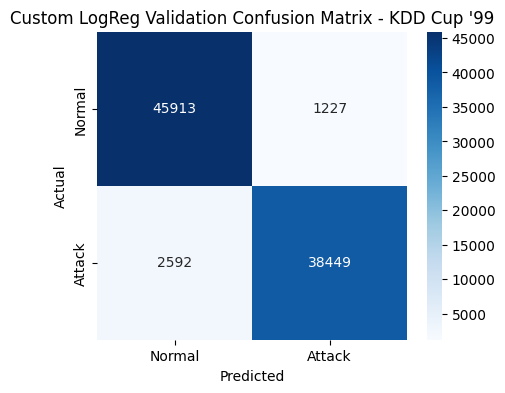


Validation set performance:
Model Accuracy: 95.62%
Precision: 0.9690
Recall: 0.9358
F1 Score: 0.9521


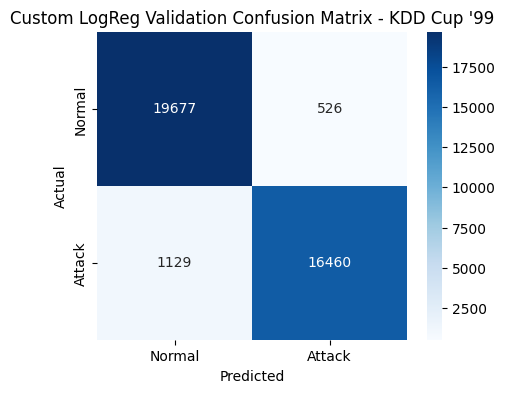


Test set performance:
Model Accuracy: 74.33%
Precision: 0.9260
Recall: 0.5968
F1 Score: 0.7258


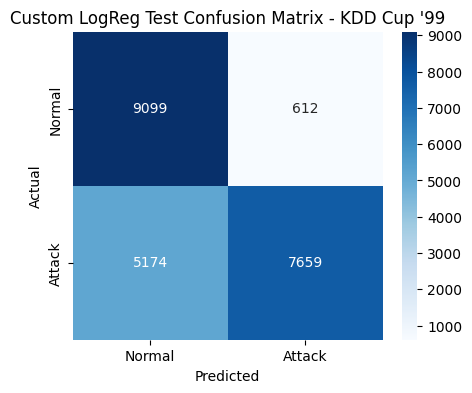

In [40]:
# Evaluate on training set
y_train_probs = log_reg.predict_proba(X_train)
y_train_pred = (y_train_probs >= best_threshold).astype(int)
print("\nTraining set performance:")
calculateAndDisplayEvaluationMetrics(y_train, y_train_pred, "Custom LogReg Validation Confusion Matrix - KDD Cup '99")

# Evaluate on validation set
y_val_probs = log_reg.predict_proba(X_val)
y_val_pred = (y_val_probs >= best_threshold).astype(int)
print("\nValidation set performance:")
calculateAndDisplayEvaluationMetrics(y_val, y_val_pred, "Custom LogReg Validation Confusion Matrix - KDD Cup '99")

# Evaluate on test set
y_test_probs = log_reg.predict_proba(X_test)
y_test_pred = (y_test_probs >= best_threshold).astype(int)
print("\nTest set performance:")
calculateAndDisplayEvaluationMetrics(y_test, y_test_pred, "Custom LogReg Test Confusion Matrix - KDD Cup '99")

In [ ]:
#Comparing with sklearn,

log_reg = SklearnLogReg(max_iter=500)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

# Compute metrics
calculateAndDisplayEvaluationMetrics(y_test, y_pred, "Confusion Matrix(Sklearn) - NSL- KDD")

In [ ]:
# Get predicted probabilities
y_probs = log_reg.predict_proba(X_test)[:, 1]

# Tune threshold to further improve performance
best_thresh = plot_threshold_vs_metrics(y_test, y_probs)

# Predict using best threshold
y_pred_thresh = (y_probs >= best_thresh).astype(int)

# Final evaluation
calculateAndDisplayEvaluationMetrics(y_test, y_pred_thresh, f"Final Confusion Matrix(Sklearn) - Threshold = {best_thresh:.2f}")
